<a href="https://colab.research.google.com/github/tarleproton/data-test/blob/main/IT_SF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Пояснения к данным**:
 - 	agreement - датасет, содержащий в себе договора с клиентами и основные характеристики необходимые для задач;
 - 	cash - история по операциям, выполняемым относительно договоров, как со стороны клиентов, так и со стороны компании;
        - agree_id - id договора;
        - person_id - id клиента;
        - loan_money - сумма в рублях, на которую был составлен договор изначально;
        - loan_days - количество дней, на которые был составлен договор изначально;
        - date_create - дата создания договора;
        - agree_status_id - статус договора (12 - Договор подписан;13 -Договор подписан;16 - Действующий;17 - Действующий;19 - закрытый договор;20 - просрочен;);
        - fact_loan_days - cколько дней длился/длится по факту;
        - daily_percent - процент, который начисляется к итоговой сумме для погашения на ежедневной основе в рамках каждого договора;
        - date_create_transaction - дата создания записи по выполненной операции (транзакции);
        - status_id - id статуса, который расшифровывает тип операции (60 - погашение займа; 62 -выдача займа);
        - amount - сумма в рублях, на которые была произведена та или иная операция;


# <a name="1common."></a>
## <a name="0.0"></a>Содержание:
* [1. Анализ данных и их обработка](#0.)
* [2. Вычислите кол-во закрытых и открытых договоров за весь данный период (операции должны покрывать друг друга);](#8.)
* [3. Проведите оценку прибыли, которую получила компания в сравнение с тем, что выдали и что получили по уже закрытым договорам;](#9.)
* [4. Постройте три недельные когорты по следующим срезам::](#10.)
    * [Количество выдач/заключенных договоров (сколько всего и на какие средние суммы);](#11.)
    * [Количество закрытых договоров (количество и средняя прибыль, которую компания получила с них по итогу);](#12.)
    * [Корректным будет искать договора где заемщик рассчитался за кредит и по ним вычеслить среднию прибыль.](#13.)
    * [Какие изменения за каждую неделю по отношению к предыдущей по выплатам со стороны клиентов;](#14.)
* [5. Кластерезация  клиентов (person_id) по двум параметрам: частота заключенных договоров и суммы, на которые эти договора заключались;](#16.)

## 1. Анализ данных и их обработка
<a name="0."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [ ]:
cash  = pd.read_json('cash.json')

In [ ]:
cash.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209147 entries, 0 to 209146
Data columns (total 5 columns):
agree_id                   209147 non-null int64
date_create_transaction    209147 non-null int64
amount                     209147 non-null float64
person_id                  209147 non-null int64
status_id                  209147 non-null int64
dtypes: float64(1), int64(4)
memory usage: 9.6 MB


In [ ]:
cash.duplicated().sum()#наличие полных дубликатов

155

In [ ]:
cash.head()

,agree_id,date_create_transaction,amount,person_id,status_id
0,1352390,1590969778615,6237.0,1408412,59
1,1372070,1590970073693,-31780.0,1922331,62
2,1372449,1590970200503,56135.8,1686194,60
3,1364376,1590970538773,19024.6,2134626,60
4,1360366,1590970557056,31329.2,2090871,60


In [ ]:
agreement   = pd.read_json('agreement.json')

In [ ]:
agreement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59533 entries, 0 to 59532
Data columns (total 8 columns):
person_id          59533 non-null int64
agree_id           59533 non-null int64
loan_money         59533 non-null int64
loan_days          59533 non-null float64
date_create        59533 non-null int64
daily_percent      59533 non-null float64
agree_status_id    59533 non-null int64
fact_loan_days     59533 non-null float64
dtypes: float64(3), int64(5)
memory usage: 4.1 MB


In [ ]:
agreement.tail()

,person_id,agree_id,loan_money,loan_days,date_create,daily_percent,agree_status_id,fact_loan_days
59528,2281802,1438321,17780,84.0,1603557027115,2.8,16,2.8
59529,2299522,1438257,17780,42.0,1603549965425,2.8,16,5.6
59530,1748207,1438015,17780,84.0,1603528113748,2.8,16,5.6
59531,2239164,1435151,23380,42.0,1603038532476,2.8,19,14.0
59532,2163190,1438258,9380,42.0,1603549969963,2.8,16,5.6


In [ ]:
agreement.duplicated().sum()

0

In [ ]:
len(agreement['agree_id'].unique())
#количество уникальных договоров

59533

In [ ]:
len(cash['agree_id'].unique())
#количество уникальных договоров

75026

In [ ]:
#изменим формат даты. unix time, но мс.
cash['date_create_transaction'] = pd.to_datetime(round(cash['date_create_transaction']/1000), unit='s')

In [ ]:
agreement['date_create'] = pd.to_datetime(round(agreement['date_create']/1000), unit='s')

**За отправную точку можено взять уникальный id договора в agreement. И на его основе объединить две таблицы.
Часть договоров пропадет. Но это те договора, у которых априори будет отсутствовать дата создания. Поскольку важным для выполнения задачи является покрывание операций друг другом, а у нас появятся те договора, в которых не будет известна дата их создания, соответственно, мы не сможем посчитать нужные нам показатели, удаление именно этой части данных считаю обоснованным.**

In [ ]:
df = cash.merge(agreement, on='agree_id', how='right')#объеденим таблици

In [ ]:
df.drop(['person_id_y'], axis='columns', inplace=True)

**Изучим сводную таблицу**

In [ ]:
df.head()

,agree_id,date_create_transaction,amount,person_id_x,status_id,loan_money,loan_days,date_create,daily_percent,agree_status_id,fact_loan_days
0,1372926,2020-06-01 06:36:18,-23380.0,2134182.0,62.0,23380,42.0,2020-06-01 06:29:31,2.8,19,109.2
1,1372926,2020-06-23 06:09:53,5143.6,2134182.0,59.0,23380,42.0,2020-06-01 06:29:31,2.8,19,109.2
2,1372926,2020-07-10 08:40:48,27354.6,2134182.0,60.0,23380,42.0,2020-06-01 06:29:31,2.8,19,109.2
3,1372929,2020-06-01 06:52:21,-28980.0,2182455.0,62.0,28980,42.0,2020-06-01 06:48:53,2.8,19,42.0
4,1372929,2020-06-16 06:08:07,33327.0,2182455.0,60.0,28980,42.0,2020-06-01 06:48:53,2.8,19,42.0


In [ ]:
df.describe()
#странно, но средняя по amount отрицательна. фирма работает в убыток? что-то не так, позже проверим.

,agree_id,amount,person_id_x,status_id,loan_money,loan_days,daily_percent,agree_status_id,fact_loan_days
count,1.619550e+05,161951.000000,1.619510e+05,161951.000000,161955.000000,161955.000000,161955.000000,161955.000000,161955.000000
mean,1.401169e+06,-1380.603708,1.927744e+06,60.576310,28927.550245,61.476835,2.799714,18.771887,108.851511
std,1.745184e+04,26013.783300,4.595645e+05,1.148726,14536.350012,21.067964,0.013868,0.936783,91.688708
min,1.372926e+06,-168000.000000,5.930000e+02,59.000000,1400.000000,14.000000,2.128000,12.000000,0.000000
25%,1.386500e+06,-17780.000000,1.836525e+06,60.000000,17780.000000,42.000000,2.800000,19.000000,39.200000
50%,1.399863e+06,1686.776000,2.113558e+06,60.000000,23380.000000,56.000000,2.800000,19.000000,84.000000
75%,1.414693e+06,12894.000000,2.213616e+06,62.000000,37380.000000,84.000000,2.800000,19.000000,159.600000
max,1.439191e+06,108458.000000,2.300950e+06,62.000000,168000.000000,352.800000,2.800000,20.000000,411.600000


In [ ]:
df['date_create_transaction'].describe()
#в нашем распоряжении данные за период с 2020-06-01 06:36:18 по 2020-10-26 14:08:29.
#это значит, что будут договора, заключенные ранее первой даты предоставленных данных(их мы уже исключили)
#и будут договора, заключенные в последние даты нашего периода, но по ним не проводились операции.

count                  161951
unique                 158932
top       2020-09-27 15:23:00
freq                        4
first     2020-06-01 06:36:18
last      2020-10-26 14:08:29
Name: date_create_transaction, dtype: object

In [ ]:
df[df['amount'].isnull()]#договора подписаны , но данные не внесены или операций по счету нет. 
#Их не стоит учитывать при анализе.

,agree_id,date_create_transaction,amount,person_id_x,status_id,loan_money,loan_days,date_create,daily_percent,agree_status_id,fact_loan_days
161951,1438395,NaT,NaN,NaN,NaN,56980,84.0,2020-10-24 19:01:57,2.8,12,0.0
161952,1438747,NaT,NaN,NaN,NaN,34580,42.0,2020-10-25 14:53:31,2.8,12,0.0
161953,1438991,NaT,NaN,NaN,NaN,40180,56.0,2020-10-26 08:07:14,2.8,12,0.0
161954,1435798,NaT,NaN,NaN,NaN,23380,84.0,2020-10-19 22:35:48,2.8,12,0.0


In [ ]:
df.dropna(subset = ['amount'], inplace = True)

In [ ]:
df.query('status_id == (59) and amount < 0')
#во всех строках, в которых status_id не является стандартным значением(а именно 60 или 62),
#сумма произведенной операции положительная. А это значит, что все их можно отнести к погашению займа(60)

,agree_id,date_create_transaction,amount,person_id_x,status_id,loan_money,loan_days,date_create,daily_percent,agree_status_id,fact_loan_days


In [ ]:
df['status_id'].replace((59), 60, inplace=True)#заменил нестандартные значения

In [ ]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
#удалим полные дубликаты

In [ ]:
df.query('person_id_x == 2138029 and agree_id == 1399898').head()
#но по факту бывают вот такие ситуации. ложная фиксация выдачи денег.
#похоже, именно они и дают отрицательную среднюю по amount
#возможно, сбой в системе: стоит обратить на это внимание ответственных за этот этап.

,agree_id,date_create_transaction,amount,person_id_x,status_id,loan_money,loan_days,date_create,daily_percent,agree_status_id,fact_loan_days
80973,1399898,2020-08-07 04:04:25,-56980.0,2138029.0,62.0,56980,84.0,2020-08-07 04:03:32,2.8,19,78.4
80974,1399898,2020-08-07 04:06:26,-56980.0,2138029.0,62.0,56980,84.0,2020-08-07 04:03:32,2.8,19,78.4
80975,1399898,2020-08-07 04:08:28,-56980.0,2138029.0,62.0,56980,84.0,2020-08-07 04:03:32,2.8,19,78.4
80976,1399898,2020-08-07 05:00:36,-56980.0,2138029.0,62.0,56980,84.0,2020-08-07 04:03:32,2.8,19,78.4
80977,1399898,2020-08-07 06:15:15,-56980.0,2138029.0,62.0,56980,84.0,2020-08-07 04:03:32,2.8,19,78.4


In [ ]:
df.duplicated(['date_create','agree_id', 'status_id', 'amount']).sum()
#и таких случаев не мало

10729

In [ ]:
#удалим их 
df.drop_duplicates(['date_create','agree_id', 'status_id', 'amount'], inplace=True)

In [ ]:
df.query('agree_status_id == (12,13,16,17)').head()
#это те договора, которые на момент выгрузки данных действуют.
#т.е. по ним не известен финальный рузультат.
#в основном это длительные договора или заключенные недавно от момента выгрузки данных.
#они не пригодятся нам в задании.

#видно, что в fact_loan_days есть некорректные занчения
#кредит взят в июне 2020 г, а в строке его длительности по факту указано 403 дня.

,agree_id,date_create_transaction,amount,person_id_x,status_id,loan_money,loan_days,date_create,daily_percent,agree_status_id,fact_loan_days
3700,1374187,2020-06-04 08:41:03,-17780.0,2015402.0,62.0,17780,84.0,2020-06-04 08:12:32,2.8,17,403.2
3701,1374187,2020-07-24 02:47:25,8890.0,2015402.0,60.0,17780,84.0,2020-06-04 08:12:32,2.8,17,403.2
3702,1374187,2020-08-25 19:21:04,5689.6,2015402.0,60.0,17780,84.0,2020-06-04 08:12:32,2.8,17,403.2
3703,1374187,2020-09-12 11:49:47,3200.4,2015402.0,60.0,17780,84.0,2020-06-04 08:12:32,2.8,17,403.2
3704,1374187,2020-09-29 14:48:17,3022.6,2015402.0,60.0,17780,84.0,2020-06-04 08:12:32,2.8,17,403.2


In [ ]:
df.drop(df.query('agree_status_id == (12,13,16,17)').index, inplace=True)

In [ ]:
#вот ещё проблемные значения.
#в них выданная сумма превышает одобренную.
#в связи с этим происходит уточнение выданной суммы и появляется повторная запись о выдаче.
#29 значений

drop_index = df[df['status_id'] == 62].loc[df[df['status_id'] == 62].duplicated(['date_create','agree_id', 'status_id'], \
                                                                                keep='last')].index
df.drop(drop_index, inplace=True)

In [ ]:
df.describe()
#так лучше
#23815 уникальных клиентов
#47355 уникальных договоров

,agree_id,amount,person_id_x,status_id,loan_money,loan_days,daily_percent,agree_status_id,fact_loan_days
count,1.301510e+05,130151.000000,1.301510e+05,130151.000000,130151.000000,130151.000000,130151.000000,130151.000000,130151.000000
mean,1.398650e+06,733.557659,1.935424e+06,60.727693,28139.435271,60.642328,2.799933,19.114767,102.857527
std,1.629298e+04,26790.697855,4.508364e+05,0.962214,14044.979395,20.411361,0.006716,0.318741,90.173810
min,1.372926e+06,-168000.000000,5.930000e+02,60.000000,1400.000000,14.000000,2.128000,19.000000,0.000000
25%,1.384816e+06,-17780.000000,1.845944e+06,60.000000,17780.000000,42.000000,2.800000,19.000000,39.200000
50%,1.397136e+06,2433.648000,2.117803e+06,60.000000,23380.000000,53.200000,2.800000,19.000000,78.400000
75%,1.411303e+06,17292.702000,2.213162e+06,62.000000,34580.000000,84.000000,2.800000,19.000000,142.800000
max,1.439082e+06,108458.000000,2.300439e+06,62.000000,168000.000000,352.800000,2.800000,20.000000,411.600000


Из того , что осталось:
    - fact_loan_days, loan_days лучше перевести в целые дни.
    - значения в fact_loan_days не совпадают с временным промежутком от взятия денег клиентом до полного погашения долга.
    - значения начисляемого % не совпадало с суммой возвращаемых денег.
    

## 2. Вычислите кол-во закрытых и открытых договоров за весь данный период (операции должны покрывать друг друга);
<a name="9."></a>
[<font size="2">(к содержанию)</font>](#1common.)

**уникальных договоров за период, в нашем случае оно равно количеству открытых**

In [ ]:
print(" {:} уникальных договоров за период"\
      .format(len(df['agree_id'].unique())))

 47355 уникальных договоров за период


In [ ]:
#перепроверка
df['status_id'].value_counts()#перепроверка

60.0    82796
62.0    47355
Name: status_id, dtype: int64

**кол-во закрытых договоров**

In [ ]:
print(" {:} закрытых договора"\
      .format(len(df['agree_id'].unique())- len(df[df['agree_status_id'] == 20]['agree_id'].unique())))

 40414 закрытых договора


**договора на просрочке**

In [ ]:
print(" {:} договора на просрочке"\
      .format(len(df[df['agree_status_id'] == 20]['agree_id'].unique())))

 6941 договора на просрочке


In [ ]:
contracts = pd.DataFrame({'уникальных договоров за период' : [len(df['agree_id'].unique())],
                   'кол-во закрытых договоров' : [len(df['agree_id'].unique())- len(df[df['agree_status_id'] == 20]\
                                                                                   ['agree_id'].unique())],
                         'договора на просрочке': [len(df[df['agree_status_id'] == 20]['agree_id'].unique())]})

In [ ]:
contracts

,уникальных договоров за период,кол-во закрытых договоров,договора на просрочке
0,47355,40414,6941


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


(-1.1064610589207586,
 1.1003076997152916,
 -1.1024943880442937,
 1.1066429273595118)

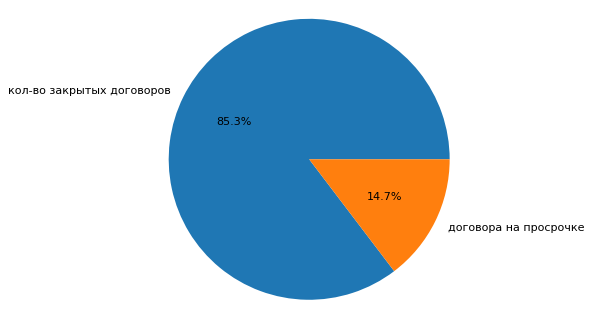

In [ ]:
vals = contracts[['кол-во закрытых договоров','договора на просрочке']].values
labels = contracts[['кол-во закрытых договоров','договора на просрочке']].columns
fig, ax = plt.subplots(figsize=(5, 5), dpi= 80)
ax.pie(vals, labels=labels,autopct='%1.1f%%')
ax.axis("equal")

## 3. Проведите оценку прибыли, которую получила компания в сравнение с тем, что выдали и что получили по уже закрытым договорам;
<a name="8."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [ ]:
profit = df.groupby('agree_status_id').agg({'amount':['sum']})/1000000
profit.columns  = profit.columns.droplevel(0)
#сумма в миллионах

In [ ]:
print("Разница между выданным деньгами и полученными, за исключением просроченных договоров: {:.2f} млн.р"\
      .format(profit['sum'].loc[19]))

Разница между выданным деньгами и полученными, за исключением просроченных договоров: 250.65 млн.р


In [ ]:
print("Убыток от просроченных договоров : {:.2f} млн.р"\
      .format(profit['sum'].loc[20]))

Убыток от просроченных договоров : -155.17 млн.р


In [ ]:
print("Доход за вычетом просроченных договоров : {:.2f} млн.р"\
      .format(profit['sum'].loc[19] + profit['sum'].loc[20]))

Доход за вычетом просроченных договоров : 95.47 млн.р


## 4. Постройте три недельные когорты по следующим срезам:
<a name="10."></a>
[<font size="2">(к содержанию)</font>](#1common.)

 **Количество выдач/заключенных договоров (сколько всего и на какие средние суммы);**
 <a name="11."></a>

In [ ]:
df['week'] = pd.DatetimeIndex(df['date_create_transaction']).week

In [ ]:
concluded_contract = df.query('week ==(40,41,42) and status_id == 62').groupby('week').agg({'loan_money':['mean'],                  
                                                                       'agree_id':['count']}).reset_index()

concluded_contract.columns = concluded_contract.columns.droplevel(1)

In [ ]:
concluded_contract.style.highlight_max(color='yellowgreen',subset=['loan_money', 'agree_id'])\
                        .highlight_min(color='coral', subset=['loan_money', 'agree_id'])
print('Cколько всего заключено договоров и на какие средние суммы')

Cколько всего заключено договоров и на какие средние суммы


 - На 30 неделе было заключено 1891 договоров на среднюю сумму в 23780.7р.
 - На 31 неделе средняя сумма договоров упала до 23691, а их количество составило 1646
 - На 32 неделе было заключено меньше всего договоров 816, но средняя сумма договора было максимальной за трехнедельный период 25496р.


**Количество закрытых договоров (количество и средняя прибыль, которую компания получила с них по итогу);**
 <a name="12."></a>

Есть вопросы:
 - daily_percent - процент не бьется с суммами возврата долга и с сроками.
 - fact_loan_days - длительность договора по факту. Но похоже она не является длительностью пользования заемными средствами.
     Это просто количество дней, прошедших на дату закрытия договора клиентом, а закрытие не равно дате погашения долга.
      - Так, что мы должны найти ? 
       - Сколько договоров закрылось в этот период или когда заемщик полностью расчитался за кредит?
      
**Корректным будет искать договора где заемщик рассчитался за кредит и по ним вычеслить среднию прибыль.**
 <a name="13."></a>

In [ ]:
#финальные платежи по кредиту
date_termination = df.groupby('agree_id').last().query('agree_status_id == 19').index

In [ ]:
closed_contracts = df.query('week ==(40,41,42) and agree_id in @date_termination').\
            pivot_table(index=['week', 'agree_id'], values='amount', aggfunc='sum').reset_index()\
                    .groupby('week').agg({'agree_id':['count'],
                                          'amount':['mean']}                                                                                        
                                         ).reset_index()
closed_contracts
print('Количество закрытых договоров и средняя прибыль, которую компания получила с них по итогу')

Количество закрытых договоров и средняя прибыль, которую компания получила с них по итогу


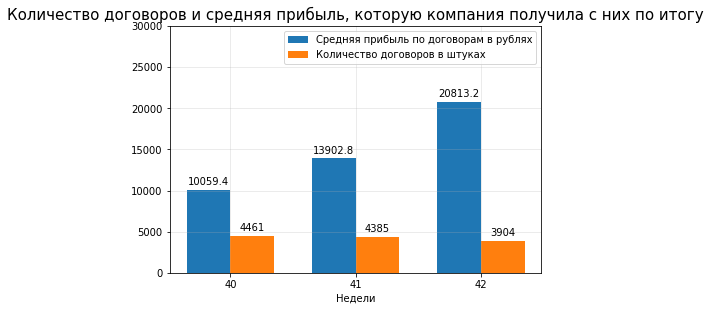

In [ ]:
N = 3
ind = np.arange(N)    
width = 0.35       

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, closed_contracts['amount', 'mean'].round(1), width
                )
rects2 = ax.bar(ind + width/2, closed_contracts['agree_id', 'count'].round(1), width
                )

def autolabel(rects, xpos='center'):
   
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3), 
                    textcoords="offset points",  
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")

fig.tight_layout()


plt.xlabel('Недели')
plt.title('Количество договоров и средняя прибыль, которую компания получила с них по итогу', fontsize=15)
plt.xticks(ind, ('40', '41', '42'))
plt.legend((rects1[0], rects2[0]), ('Средняя прибыль по договорам в рублях', 'Количество договоров в штуках'))
plt.grid(axis='both', alpha=.3)
plt.ylim(0, 30000)
plt.show()

**Какие изменения за каждую неделю по отношению к предыдущей по выплатам со стороны клиентов;**
 <a name="14."></a>

In [ ]:
changing_payouts = df.query('week ==(39,40,41,42) and status_id == 60').groupby('week').agg({'amount':['sum']}                                                                                        
                                                                           ).diff().reset_index().round(1)
changing_payouts.columns = changing_payouts.columns.droplevel(1)
changing_payouts
print('Изменения за каждую неделю по отношению к предыдущей по выплатам со стороны клиентов')

Изменения за каждую неделю по отношению к предыдущей по выплатам со стороны клиентов


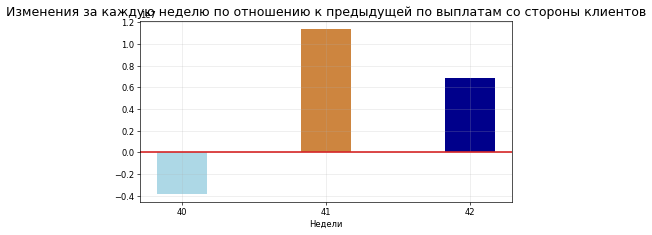

In [ ]:
import random

all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=3)
width = 0.35 

plt.figure(figsize=(8,4), dpi= 60)
plt.bar(changing_payouts['week'],changing_payouts['amount'],   color=c, width=width)
plt.xticks(range(40, 43, 1))
plt.grid(axis='both', alpha=.3)
plt.xlabel('Недели')
plt.title('Изменения за каждую неделю по отношению к предыдущей по выплатам со стороны клиентов', fontsize=15)
plt.axhline(linewidth=2, color='#d62728')
plt.show()

 - В нашем случае с каждой последующеей неделей выплата со стороны клиентов становилось меньше

## 5. Кластерезация  клиентов (person_id) по двум параметрам: частота заключенных договоров и суммы, на которые эти договора заключались;
<a name="16."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [ ]:
person_id = df.groupby('person_id_x').agg({'agree_id':['count'],
                              'loan_money':['sum']}                                                                                        
                                                  )
person_id.columns = person_id.columns.droplevel(1)

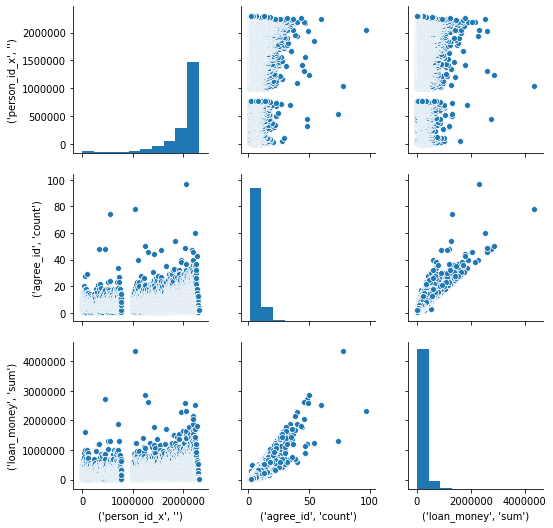

In [ ]:
sns.pairplot(df.groupby('person_id_x').agg({'agree_id':['count'],
                              'loan_money':['sum']}                                                                                        
                                                  ).reset_index(), diag_kind='hist')

Определим оптимальное количество кластеров

In [ ]:
%%time
distortion = []
K = range(1,12)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(person_id)
    distortion.append(model.inertia_) 

CPU times: user 11.1 s, sys: 9.11 s, total: 20.2 s
Wall time: 20.3 s


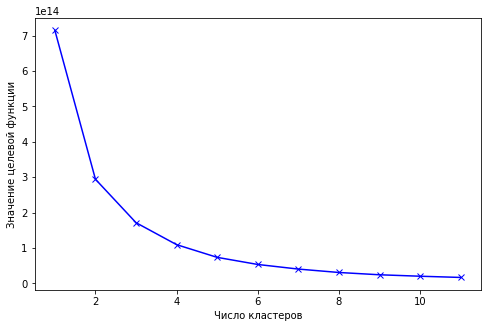

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show() 

После 4 кластеров целевая функция выходит на плато. Но посмотрев на разбиение кластеров, решил добавить ещё один. Он лучше отделил сегмент заемщиков, берущих крупные суммы.

In [ ]:
model = KMeans(n_clusters=5, random_state=12345)
model.fit(person_id)
centroids = pd.DataFrame(model.cluster_centers_, columns=person_id.columns)

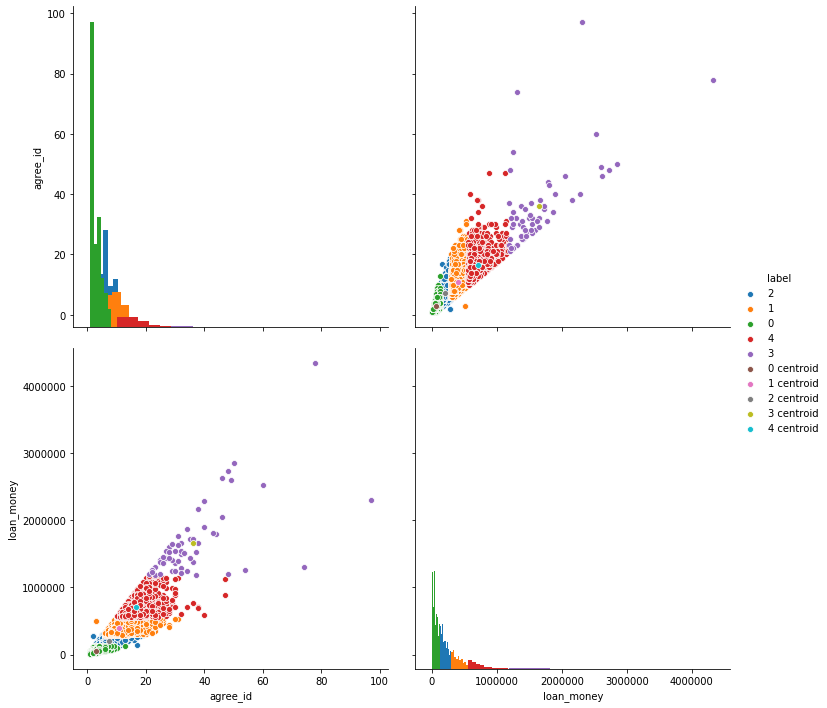

In [ ]:
person_id['label'] = model.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid', '2 centroid', '3 centroid', '4 centroid']
person_id_all = pd.concat([person_id, centroids], ignore_index=True)

sns.pairplot(person_id_all, hue='label', diag_kind='hist', height=5)

In [ ]:
person_id

,agree_id,loan_money,label
person_id_x,,,
593.0,5,172900,2
1576.0,10,478800,1
3332.0,6,299880,1
4904.0,4,76720,0
5303.0,4,82320,0
...,...,...,...
2299548.0,2,18760,0
2299909.0,4,48720,0
2300107.0,2,16800,0


Основой является получение максимальной прибыли при минимизации рисков. Если по поводу второго - естественно приходит в голову выделить кластер с теми, кто не вернул кредиты и наоборот. То по поводу увеличения прибыли более приоритетными могут быть клиенты, берущие займ на продолжительный срок и крупную сумму. Можно выделить кластер с теми, кто берет деньги на день, два - это явно отдельная каста. Возможно разделение по сезонности.

In [ ]:
#выгрузим таблицу
!pip install openpyxl
with pd.ExcelWriter('fin.xlsx') as writer:  
    df.to_excel(writer, sheet_name='Sheet_name_1')
    contracts.to_excel(writer, sheet_name='Sheet_name_2')
    concluded_contract.to_excel(writer, sheet_name='Sheet_name_3')
    closed_contracts.to_excel(writer, sheet_name='Sheet_name_4')
    changing_payouts.to_excel(writer, sheet_name='Sheet_name_5')

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 242 kB 3.0 MB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8915 sha256=c37aa374a609f41d5423b113260a74ce218f459c6698323f474f080406008875
  Stored in directory: /home/jovyan/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile
